# Classic Classifier as Benchmark

The main goal of this exercise is to get a feeling and understanding on the importance of
representation and extraction of information from complex media content, in this case images or
text. You will thus get some datasets that have an image classification target.  

(1) In the first step, you shall try to find a good classifier with „traditional“ feature extraction
methods. Thus, pick one feature extractor based on e.g. Bag Of Words, or n-grams, or similar
You shall evaluate them on two shallow algorithms, optimising the parameter settings to see what
performance you can achieve, to have a baseline for the subsequent steps.


In [3]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


## Loading the data

### Dataset 1 


In [16]:
file_path = "Data/fake_and_real_news_dataset.csv" 
dataset1 = pd.read_csv(file_path, encoding="utf-8", on_bad_lines='skip')

dataset1.columns = ['iid', 'title', 'text', 'label']

print(dataset1.head())

          iid                                              title  \
0  Fq+C96tcx+  ‘A target on Roe v. Wade ’: Oklahoma bill maki...   
1  bHUqK!pgmv  Study: women had to drive 4 times farther afte...   
2  4Y4Ubf%aTi        Trump, Clinton clash in dueling DC speeches   
3  _CoY89SJ@K  Grand jury in Texas indicts activists behind P...   
4  +rJHoRQVLe  As Reproductive Rights Hang In The Balance, De...   

                                                text label  
0  UPDATE: Gov. Fallin vetoed the bill on Friday....  REAL  
1  Ever since Texas laws closed about half of the...  REAL  
2  Donald Trump and Hillary Clinton, now at the s...  REAL  
3  A Houston grand jury investigating criminal al...  REAL  
4  WASHINGTON -- Forty-three years after the Supr...  REAL  


## Pre-Processing: Dataset 1

We encoded the labels, converting 'FAKE' to 0 and 'REAL' to 1.

Next, we combined the 'title' and 'text' columns into a single 'combined_text' column.

The text was then converted to lowercase to ensure consistency.

Special characters and punctuation were removed using a regular expression.


We initialized the 'Snowball Stemmer' to reduce words to their root forms and defined a set of English stopwords. The text was further processed by removing stopwords and applying stemming directly to the words. Finally, we dropped the intermediate 'combined_text' column to clean up the dataset. 

### Dealing with missing values

In [17]:
dataset1['label'].fillna('FAKE', inplace=True)

print(dataset1['label'].isnull().sum())

0


/var/folders/0n/ynd9lk_93kd3xbz1hdvjw87w0000gn/T/ipykernel_76236/4198616755.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset1['label'].fillna('FAKE', inplace=True)


### Encoding + Text Cleaning

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

# encoding label column
dataset1['label'] = dataset1['label'].map({'FAKE': 0, 'REAL': 1})

# combining title and text into a new column
dataset1['combined_text'] = dataset1['title'] + " " + dataset1['text']

# converting combined column to lowercase
dataset1['combined_text'] = dataset1['combined_text'].str.lower()

# removing special characters and punctuation signs
dataset1['combined_text'] = dataset1['combined_text'].apply(lambda x: re.sub(r'\W+', ' ', str(x)))

# removing numbers
dataset1['combined_text'] = dataset1['combined_text'].apply(lambda x: re.sub(r'\d+', '', x))

[nltk_data] Downloading package punkt to /Users/luisavend/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luisavend/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Stemming

In [19]:
from nltk.stem import SnowballStemmer

snowball = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))  

dataset1['combined_text_processed'] = dataset1['combined_text'].apply(
    lambda text: ' '.join([snowball.stem(word) for word in text.split() if word not in stop_words])
)

dataset1 = dataset1.drop(columns=['combined_text'])

### Data Splitting

In [20]:
dataset1_X_train, dataset1_X_test, dataset1_y_train, dataset1_y_test = train_test_split(
    dataset1['combined_text_processed'].tolist(),  
    dataset1['label'],                             
    test_size=0.25,                                
    random_state=69                                
)

## N-Gram Feature Extraction

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# initializing CountVectorizer with n-grams (bigrams)
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=50000)

# fitting and transforming training data
X_train_ngrams = vectorizer.fit_transform(dataset1_X_train)

# transforming test data using the same vocabulary
X_test_ngrams = vectorizer.transform(dataset1_X_test)

# printing the shape
print(f"N-Gram Training Data Shape: {X_train_ngrams.shape}")
print(f"N-Gram Test Data Shape: {X_test_ngrams.shape}")

# checking the first 20 n-grams
print(vectorizer.get_feature_names_out()[:20])


N-Gram Training Data Shape: (3445, 50000)
N-Gram Test Data Shape: (1149, 50000)
['aa superlumin' 'aaron blake' 'abandon trump' 'abbi phillip' 'abc georg'
 'abc good' 'abc news' 'abc poll' 'abc report' 'abc washington' 'abc week'
 'abdul jabbar' 'abedin clinton' 'abedin email' 'abedin estrang'
 'abedin hillari' 'abedin mill' 'abedin weiner' 'abedini said'
 'abel danger']


## LTSM Classifier

Next we performed text tokenization and sequence padding to prepare text data for machine learning models. The Tokenizer converts words into unique integers, creating a vocabulary from the training data.  The sequences are padded (or truncated) to a fixed length (maxlen) to ensure uniform input size for the model.

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
text_tokenizer = Tokenizer()

text_tokenizer.fit_on_texts(dataset1_X_train)

train_sequences = text_tokenizer.texts_to_sequences(dataset1_X_train)
test_sequences = text_tokenizer.texts_to_sequences(dataset1_X_test)

max_length = 500  
training_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
testing_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [23]:
word_index_dataset1 = text_tokenizer.word_index
vocabulary_size = len(word_index_dataset1)

print("Vocabulary Size:", vocabulary_size)
print("Word Index:", word_index_dataset1)

Vocabulary Size: 33969
Word Index: {'trump': 1, 'clinton': 2, 'said': 3, 'state': 4, 'would': 5, 'campaign': 6, 'one': 7, 'republican': 8, 'peopl': 9, 'presid': 10, 'new': 11, 'say': 12, 'elect': 13, 'like': 14, 'democrat': 15, 'time': 16, 'hillari': 17, 'year': 18, 'parti': 19, 'vote': 20, 'support': 21, 'also': 22, 'polit': 23, 'go': 24, 'obama': 25, 'american': 26, 'candid': 27, 'us': 28, 'even': 29, 'make': 30, 'sander': 31, 'voter': 32, 'could': 33, 'get': 34, 'nation': 35, 'donald': 36, 'first': 37, 'report': 38, 'call': 39, 'presidenti': 40, 'work': 41, 'countri': 42, 'mani': 43, 'day': 44, 'use': 45, 'two': 46, 'cruz': 47, 'want': 48, 'right': 49, 'think': 50, 'take': 51, 'win': 52, 'govern': 53, 'back': 54, 'poll': 55, 'know': 56, 'way': 57, 'come': 58, 'need': 59, 'email': 60, '2016': 61, 'last': 62, 'percent': 63, 'debat': 64, 'show': 65, 'u': 66, 'point': 67, 'news': 68, 'hous': 69, 'week': 70, 'world': 71, 'well': 72, 'white': 73, 'may': 74, 'former': 75, 'america': 76, 'w

In [24]:
training_padded_sequences[1]

array([ 601,  116,   14,  643,   17,    2,   61,  848,  112,   17,    2,
       2106,   25,  304,  286, 2426, 1232,  341,   80,   79,  368,  158,
         75,  185,    4,   82,  179,  685,  354,   66, 1545,  308,  413,
        601, 1265, 4678, 3290,  509,  451, 1404,    2,  568, 1168,  819,
        632,  116,  601,  346,  651,  391, 1244,  124, 1432,  130, 1143,
        119,  728,    7, 2394,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Creating Embedding Index

In [25]:
import numpy as np

glove_embeddings = {}
with open('Data/glove.6B.100d.txt', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]  
        vector = np.asarray(values[1:], dtype='float32') 
        glove_embeddings[word] = vector

print(f"Loaded {len(glove_embeddings)} word vectors.")

Loaded 400000 word vectors.


### Creating Embedding Matrix

In [26]:
embedding_matrix = np.zeros((vocabulary_size + 1, 100))  
for word, index in word_index_dataset1.items():
    embedding_vector = glove_embeddings.get(word) 
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector 

print("Embedding vector for the word at index 1:")
print(embedding_matrix[1])

Embedding vector for the word at index 1:
[-0.15730999 -0.75502998  0.36844999 -0.18957999 -0.16896001 -0.23157001
 -0.22657999 -0.30186     0.24372     0.61896002  0.58995003  0.047638
 -0.055164   -0.70210999  0.22084001 -0.69231999  0.49419001  1.42850006
 -0.25362     0.20031001 -0.26192001  0.05315    -0.048418   -0.44982001
  0.54644001 -0.014645   -0.015531   -0.61197001 -0.91964    -0.75279999
  0.64842999  1.0934      0.052682    0.33344999  0.10532     0.59517002
  0.023104   -0.37105     0.29749    -0.23683     0.079566   -0.10326
  0.35885    -0.28935    -0.19881     0.22908001 -0.061435    0.56127
 -0.017115   -0.32868001 -0.78416997 -0.49375001  0.34944001  0.16278
 -0.061168   -1.31060004  0.39151999  0.124      -0.20873    -0.18472999
 -0.56184     0.55693001  0.012114   -0.54544997 -0.31409001  0.1
  0.31542999  0.74756998 -0.47734001 -0.18332    -0.65622997  0.40768
 -0.30697    -0.47246999 -0.7421     -0.44977999 -0.078122   -0.52673
 -0.70633     1.32710004  0.26298

### Training the LSTM Classifier

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense

In [28]:
lstm_model1 = Sequential([
    Embedding(input_dim=vocabulary_size + 1, output_dim=100 , input_length=max_length, weights=[embedding_matrix], trainable=False),
    Dropout(rate=0.2),  
    LSTM(units=128),  
    Dropout(rate=0.2),  
    Dense(units=256, activation='relu'),  
    Dense(units=1, activation='sigmoid')  
])

lstm_model1.build(input_shape=(None, max_length))

lstm_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model1.summary()

lstm_model2 = Sequential([
    Embedding(input_dim=vocabulary_size + 1, output_dim=100 , input_length=max_length, weights=[embedding_matrix], trainable=False),
    Dropout(rate=0.2),  
    LSTM(units=128, return_sequences=True),  
    Dropout(rate=0.2),  
    LSTM(units=128),  
    Dense(units=256, activation='relu'),  
    Dense(units=1, activation='sigmoid')  
])

lstm_model2.build(input_shape=(None, max_length))

lstm_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model2.summary()

lstm_model3 = Sequential([
    Embedding(input_dim=vocabulary_size + 1, output_dim=100 , input_length=max_length, weights=[embedding_matrix], trainable=False),
    Dropout(rate=0.5),  
    LSTM(units=128),
    Dropout(rate=0.5), 
    Dense(units=256, activation='relu'),  
    Dense(units=1, activation='sigmoid')  
])

lstm_model3.build(input_shape=(None, max_length))

lstm_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          3397000   
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,547,529
Trainable params: 150,529
Non-tr

In [29]:
training_history1 = lstm_model1.fit(
    training_padded_sequences, dataset1_y_train,  # using padded sequences
    validation_data=(testing_padded_sequences, dataset1_y_test),
    epochs=10,
    batch_size=256
)

training_history2 = lstm_model2.fit(
    training_padded_sequences, dataset1_y_train,  # using padded sequences
    validation_data=(testing_padded_sequences, dataset1_y_test),
    epochs=10,
    batch_size=256
)

training_history3 = lstm_model3.fit(
    training_padded_sequences, dataset1_y_train,  # using padded sequences
    validation_data=(testing_padded_sequences, dataset1_y_test),
    epochs=10,
    batch_size=256
)

Epoch 1/10
14/14 [==============================] - 9s 567ms/step - loss: 0.6602 - accuracy: 0.6093 - val_loss: 0.6211 - val_accuracy: 0.6580
Epoch 2/10
14/14 [==============================] - 7s 525ms/step - loss: 0.6479 - accuracy: 0.6644 - val_loss: 0.5677 - val_accuracy: 0.7093
Epoch 3/10
14/14 [==============================] - 7s 528ms/step - loss: 0.6022 - accuracy: 0.6871 - val_loss: 0.5680 - val_accuracy: 0.7337
Epoch 4/10
14/14 [==============================] - 7s 534ms/step - loss: 0.5936 - accuracy: 0.7495 - val_loss: 0.5365 - val_accuracy: 0.7842
Epoch 5/10
14/14 [==============================] - 7s 535ms/step - loss: 0.5153 - accuracy: 0.7808 - val_loss: 0.5401 - val_accuracy: 0.7894
Epoch 6/10
14/14 [==============================] - 7s 525ms/step - loss: 0.4892 - accuracy: 0.7872 - val_loss: 0.4878 - val_accuracy: 0.7972
Epoch 7/10
14/14 [==============================] - 7s 527ms/step - loss: 0.5163 - accuracy: 0.7617 - val_loss: 0.5597 - val_accuracy: 0.6693
Epoch 

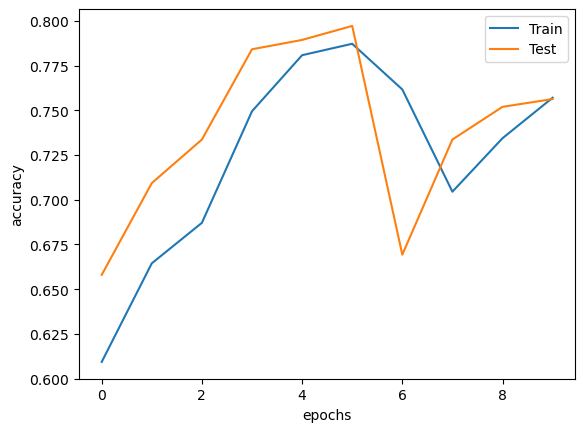

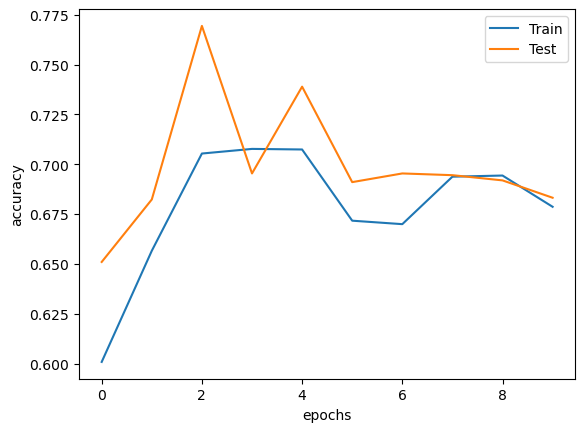

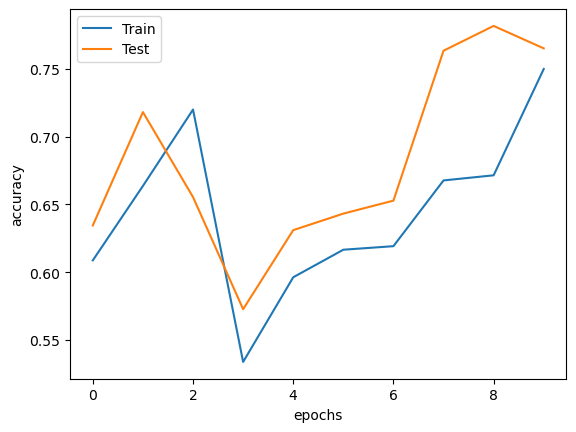

In [59]:
# visualize the results
plt.plot(training_history1.history['accuracy'])
plt.plot(training_history1.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(training_history2.history['accuracy'])
plt.plot(training_history2.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(training_history3.history['accuracy'])
plt.plot(training_history3.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

## Pre-Processing: Dataset 2

### Loading the data

In [30]:
true_df = pd.read_csv("Data/True.csv")
fake_df = pd.read_csv("Data/Fake.csv")


true_df["label"] = 1  
fake_df["label"] = 0  

dataset2 = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

dataset2 = dataset2.drop(columns=["date", "subject"])

dataset2 = dataset2.sample(n = 2000, random_state=69)

#### Checking for missing values


In [31]:
print(dataset2.isnull().sum())
dataset2 = dataset2.dropna()

title    0
text     0
label    0
dtype: int64


##### The pre-processing is done in the same way as for dataset 1

In [32]:
nltk.download('punkt')
nltk.download('stopwords')


dataset2['combined'] = dataset2['title'] + " " + dataset2['text']

dataset2['combined'] = dataset2['combined'].str.lower()

dataset2['combined'] = dataset2['combined'].apply(lambda x: re.sub(r'\W+', ' ', str(x)))

dataset2['combined'] = dataset2['combined'].apply(lambda x: re.sub(r'\d+', '', x))

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))  

dataset2['preprocessed_combined'] = dataset2['combined'].apply(
    lambda text: ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
)

dataset2 = dataset2.drop(columns=['combined'])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
dataset2.head()

,title,text,label,preprocessed_combined
21347,Downfall of ex-Samsung strategy chief leaves '...,"SEOUL (Reuters) - Over four decades, Choi Gee-...",1,downfal ex samsung strategi chief leav salarym...
2583,"Attorney General Sessions visits White House, ...",ABOARD AIR FORCE ONE (Reuters) - U.S. Attorney...,1,attorney gener session visit white hous trump ...
22746,Trump Has Finally Commented On Portland Train...,Donald Trump doesn t particularly have a filte...,0,trump final comment portland train attack sort...
4756,Lawmaker says U.S. foreign surveillance 'unmas...,WASHINGTON (Reuters) - The Republican chairman...,1,lawmak say u foreign surveil unmask trump asso...
35759,SHOCKING POLL RESULTS In Primary Victories Ton...,There are no surprises with the results on the...,0,shock poll result primari victori tonight surp...


## LSTM Classifier

### Splitting the data

In [34]:
dataset2_X_train, dataset2_X_test, dataset2_y_train, dataset2_y_test = train_test_split(dataset2['preprocessed_combined'].tolist(), dataset2['label'], test_size=0.25, random_state=69)

### Tokenization and Padding

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset2_X_test)
word_index = tokenizer.word_index
vocabulary_size = len(word_index)

print(vocabulary_size, word_index)

11532 {'trump': 1, 'said': 2, 'state': 3, 'presid': 4, 'u': 5, 'would': 6, 'peopl': 7, 'one': 8, 'year': 9, 'say': 10, 'republican': 11, 'new': 12, 'like': 13, 'american': 14, 'time': 15, 'hous': 16, 'clinton': 17, 'reuter': 18, 'report': 19, 'also': 20, 'nation': 21, 'elect': 22, 'countri': 23, 'govern': 24, 'democrat': 25, 'first': 26, 'obama': 27, 'could': 28, 'right': 29, 'support': 30, 'unit': 31, 'campaign': 32, 'donald': 33, 'call': 34, 'white': 35, 'vote': 36, 'group': 37, 'two': 38, 'offici': 39, 'use': 40, 'go': 41, 'work': 42, 'told': 43, 'senat': 44, 'make': 45, 'washington': 46, 'parti': 47, 'get': 48, 'offic': 49, 'polit': 50, 'includ': 51, 'north': 52, 'former': 53, 'attack': 54, 'news': 55, 'secur': 56, 'back': 57, 'last': 58, 'want': 59, 'take': 60, 'hillari': 61, 'law': 62, 'mani': 63, 'leader': 64, 'plan': 65, 'even': 66, 'america': 67, 'day': 68, 'media': 69, 'video': 70, 'week': 71, 'polici': 72, 'may': 73, 'need': 74, 'sourc': 75, 'school': 76, 'administr': 77, 't

In [49]:
# padding data
training_sequences = tokenizer.texts_to_sequences(dataset2_X_train) #convert every word in a news to its number in the dictionary
training_padded_seq = pad_sequences(training_sequences, maxlen=500, padding='post', truncating='post') #cut off encoding after 500 words

testing_sequences = tokenizer.texts_to_sequences(dataset2_X_test) #words that are not in the dic. are skipped and dont get a number
testing_padded_seq = pad_sequences(testing_sequences, maxlen=500, padding='post', truncating='post') #cut off encoding after 500 words

In [50]:
training_padded_seq[1] 

array([  418,  1044,  1270,  1097,   439,     1,   686,  1099,    18,
          38,    19,    38,  3641,  1044,    55,  1264,   110,   191,
         632,  1193,   439,  1099,    58,    71,     8,    19,   403,
         277,    11,   106,   589,  1700,    33,     1,    19,   884,
        1765,   432,   663,  1787,   176,     1,    32,   496,  5574,
        7437,    10,  2113,   429,   686,   139,   584,   844,   108,
         196, 10495,  7437,     1,   515,   249,  1139,  2375,  4471,
        1044,  1270,   249,   496, 10932,     1,    32,  1044,   833,
         474,   176,  1139,   455,   186,  1765,  1899,   533,   718,
        7437,  2113,    88,    19,   655,  5079,    55,   632,  1044,
         403,  3641,   493,    20,   127,  3932,   162,   203,   520,
        1765,  1765,  3641,   493,  1432,  1264,   217,   506,   477,
          21,    56,  2272,  1908,  3641,  6092,  1264,   226,    88,
         565,   136,    96,   249,    55,   870,   355,  1451,   429,
           1,    32,

### Creating Embedding Index

In [51]:
embedding_index = {}
with open('Data/glove.6B.100d.txt', encoding='utf-8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


### Creating Embedding Matrix

In [52]:
# creating embedding matrix (gets rid of vectors of words that are NOT in our vocabulary)
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix[1]

array([-0.15730999, -0.75502998,  0.36844999, -0.18957999, -0.16896001,
       -0.23157001, -0.22657999, -0.30186   ,  0.24372   ,  0.61896002,
        0.58995003,  0.047638  , -0.055164  , -0.70210999,  0.22084001,
       -0.69231999,  0.49419001,  1.42850006, -0.25362   ,  0.20031001,
       -0.26192001,  0.05315   , -0.048418  , -0.44982001,  0.54644001,
       -0.014645  , -0.015531  , -0.61197001, -0.91964   , -0.75279999,
        0.64842999,  1.0934    ,  0.052682  ,  0.33344999,  0.10532   ,
        0.59517002,  0.023104  , -0.37105   ,  0.29749   , -0.23683   ,
        0.079566  , -0.10326   ,  0.35885   , -0.28935   , -0.19881   ,
        0.22908001, -0.061435  ,  0.56127   , -0.017115  , -0.32868001,
       -0.78416997, -0.49375001,  0.34944001,  0.16278   , -0.061168  ,
       -1.31060004,  0.39151999,  0.124     , -0.20873   , -0.18472999,
       -0.56184   ,  0.55693001,  0.012114  , -0.54544997, -0.31409001,
        0.1       ,  0.31542999,  0.74756998, -0.47734001, -0.18

### Training the LSTM

In [54]:
lstm_model1 = Sequential([
    Embedding(input_dim=vocabulary_size + 1, output_dim=100 , input_length=max_length, weights=[embedding_matrix], trainable=False),
    Dropout(rate=0.2),  
    LSTM(units=128),  
    Dropout(rate=0.2),  
    Dense(units=256, activation='relu'),  
    Dense(units=1, activation='sigmoid')  
])

lstm_model1.build(input_shape=(None, max_length))

lstm_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model1.summary()

lstm_model2 = Sequential([
    Embedding(input_dim=vocabulary_size + 1, output_dim=100 , input_length=max_length, weights=[embedding_matrix], trainable=False),
    Dropout(rate=0.2),  
    LSTM(units=128, return_sequences=True),  
    Dropout(rate=0.2),  
    LSTM(units=128),  
    Dense(units=256, activation='relu'),  
    Dense(units=1, activation='sigmoid')  
])

lstm_model2.build(input_shape=(None, max_length))

lstm_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model2.summary()

lstm_model3 = Sequential([
    Embedding(input_dim=vocabulary_size + 1, output_dim=100 , input_length=max_length, weights=[embedding_matrix], trainable=False),
    Dropout(rate=0.5),  
    LSTM(units=128),
    Dropout(rate=0.5), 
    Dense(units=256, activation='relu'),  
    Dense(units=1, activation='sigmoid')  
])

lstm_model3.build(input_shape=(None, max_length))

lstm_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 100)          1153300   
                                                                 
 dropout_16 (Dropout)        (None, 500, 100)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,303,829
Trainable params: 150,529
Non-

In [ ]:
training_history1 = lstm_model1.fit(
    training_padded_seq, dataset2_y_test,  # Use padded sequences
    validation_data=(testing_padded_seq, dataset2_y_test),
    epochs=10,
    batch_size=256
)

training_history2 = lstm_model2.fit(
    training_padded_seq, dataset2_y_test,  # Use padded sequences
    validation_data=(testing_padded_seq, dataset2_y_test),
    epochs=10,
    batch_size=256
)

training_history3 = lstm_model3.fit(
    training_padded_seq, dataset2_y_test,  # Use padded sequences
    validation_data=(testing_padded_seq, dataset2_y_test),
    epochs=10,
    batch_size=256
)

ValueError: Data cardinality is ambiguous:
  x sizes: 1500
  y sizes: 500
Make sure all arrays contain the same number of samples.

In [ ]:
# visualize the results
plt.plot(training_history1.history['accuracy'])
plt.plot(training_history1.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(training_history2.history['accuracy'])
plt.plot(training_history2.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(training_history3.history['accuracy'])
plt.plot(training_history3.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

# Training Classifiers

## Dataset 1: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier1 = RandomForestClassifier(n_estimators=100, random_state=69)
rf_classifier1.fit(training_padded_sequences, dataset1_y_train)
y_predicted = rf_classifier1.predict(testing_padded_sequences)
print("Random Forest Accuracy:", accuracy_score(y_predicted, dataset1_y_test))
print("\nRandom Forest Classification Report:\n", classification_report(dataset1_y_test, y_predicted, target_names=['FAKE', 'REAL']))

### Dataset 1: Random Forests with Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 350, 400],  # number of trees
    'max_depth': [10, 15, 20, 25],      # maximum depth of trees
    'min_samples_split': [2, 4, 6],  # minimum samples required to split a node
    'min_samples_leaf': [2, 4, 6]     # minimum samples required at a leaf node
}

# initializing the model
rf_classifier_tuned = RandomForestClassifier(random_state=69)

# GridSearchCV to find best parameters
grid_search = GridSearchCV(rf_classifier_tuned, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(training_padded_sequences, dataset1_y_train)

# best model from grid search
rf_classifier_tuned = grid_search.best_estimator_

# predicting with best model
y_predicted_tuned = rf_classifier_tuned.predict(testing_padded_sequences)

# evaluation metrics
print("\nBest Random Forest Hyper-Parameters:", grid_search.best_params_)
print("\nTuned Random Forest Accuracy:", accuracy_score(y_predicted_tuned, dataset1_y_test))
print("\nTuned Random Forest Classification Report:\n", classification_report(dataset1_y_test, y_predicted_tuned, target_names=['FAKE', 'REAL']))


## Dataset 1: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# converting text data into TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(dataset1_X_train)
X_test_tfidf = tfidf_vectorizer.transform(dataset1_X_test)

# initializing and training model
log_reg = LogisticRegression(max_iter=1000, random_state=69)
log_reg.fit(X_train_tfidf, dataset1_y_train)

# making predictions
y_pred_logreg = log_reg.predict(X_test_tfidf)

# evaluation metrics
print("Logistic Regression Accuracy:", accuracy_score(y_pred_logreg, dataset1_y_test))
print("\nLogistic Regression Classification Report:\n", classification_report(dataset1_y_test, y_pred_logreg, target_names=['FAKE', 'REAL']))


### Dataset 1: Logistic Regression with Hyperparameters

In [ ]:
# hyperparameter grid
param_grid_logreg = {
    'C': [1, 10, 20, 30, 40],  # regularization strength
    'penalty': ['l1', 'l2'],  # L1 = Lasso, L2 = Ridge
    'solver': ['liblinear', 'saga']  # solvers that support L1 and L2 penalties
}

# initializing tuned model
log_reg_tuned = LogisticRegression(max_iter=1000, random_state=69)

# grid search
grid_search_logreg = GridSearchCV(log_reg_tuned, param_grid_logreg, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_logreg.fit(X_train_tfidf, dataset1_y_train)

# getting the best model
best_log_reg = grid_search_logreg.best_estimator_

# predicting using the best model
y_pred_logreg_tuned = best_log_reg.predict(X_test_tfidf)

# evaluation metrics
print("\nBest Logistic Regression Parameters:", grid_search_logreg.best_params_)
print("\nTuned Logistic Regression Accuracy:", accuracy_score(y_pred_logreg_tuned, dataset1_y_test))
print("\nTuned Logistic Regression Classification Report:\n", classification_report(dataset1_y_test, y_pred_logreg_tuned, target_names=['FAKE', 'REAL']))

## Dataset 2: Random Forests

In [ ]:
rf_classifier2 = RandomForestClassifier(n_estimators=100, random_state=69)
rf_classifier2.fit(training_padded_seq, dataset2_y_train)
y_pred = rf_classifier2.predict(testing_padded_seq)
print("\nRandom Forest Accuracy:", accuracy_score(y_pred, dataset2_y_test))
print("\nRandom Forest Classification Report:\n", classification_report(dataset2_y_test, y_pred, target_names=['FAKE', 'REAL']))

### Dataset 2: Random Forests with Hyperparameters

In [ ]:
# hyperparameter grid
param_grid_rf = {
    'n_estimators': [450, 500, 550],  # number of trees
    'max_depth': [15, 20, 25],  # tree depth
    'min_samples_split': [2, 4, 6],  # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # # minimum samples required at a leaf node
}

# initializing model
rf_classifier2_tuned = RandomForestClassifier(random_state=69)

# grid search
grid_search_rf = GridSearchCV(rf_classifier2_tuned, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(training_padded_seq, dataset2_y_train)

# best model from grid search
rf_classifier2_tuned = grid_search_rf.best_estimator_

# predicting using the best model
y_pred_rf2_tuned = rf_classifier2_tuned.predict(testing_padded_seq)

# evaluation metrics
print("\nBest Random Forest Parameters:", grid_search_rf.best_params_)
print("\nTuned Random Forest Accuracy:", accuracy_score(y_pred_rf2_tuned, dataset2_y_test))
print("\nTuned Random Forest Classification Report:\n", classification_report(dataset2_y_test, y_pred_rf2_tuned, target_names=['FAKE', 'REAL']))


## Dataset 2: Logistic Regression

In [ ]:
# converting text data into TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(dataset2_X_train)
X_test_tfidf = tfidf_vectorizer.transform(dataset2_X_test)

# initializing and training model
log_reg2 = LogisticRegression(max_iter=1000, random_state=69)
log_reg2.fit(X_train_tfidf, dataset2_y_train)

# making predictions
y_pred_logreg2 = log_reg2.predict(X_test_tfidf)

# evaluation metrics
print("\nLogistic Regression Accuracy:", accuracy_score(y_pred_logreg2, dataset2_y_test))
print("\nLogistic Regression Classification Report:\n", classification_report(dataset2_y_test, y_pred_logreg2, target_names=['FAKE', 'REAL']))

### Dataset 2: Logistic Regression with Hyperparameters

In [ ]:
# hyperparameter grid
param_grid_logreg = {
    'C': [0.1, 1, 5, 10, 15, 20],  # regularization strength
    'penalty': ['l1', 'l2'],  # L1 = Lasso, L2 = Ridge
    'solver': ['liblinear', 'saga'],  # solvers that support L1 and L2 penalties
}

# initializing model
log_reg2_tuned = LogisticRegression(max_iter=1000, random_state=69)

# Grid Search
grid_search_logreg = GridSearchCV(log_reg2_tuned, param_grid_logreg, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_logreg.fit(X_train_tfidf, dataset2_y_train)

# getting the best model
best_params = grid_search_logreg.best_params_

# training model
log_reg2_tuned = LogisticRegression(**best_params, max_iter=1000, random_state=69)
log_reg2_tuned.fit(X_train_tfidf, dataset2_y_train)

# making predictions
y_pred_logreg2_tuned = log_reg2_tuned.predict(X_test_tfidf)

# evaluation metrics
print("\nBest Logistic Regression Parameters:", best_params)
print("\nTuned Logistic Regression Accuracy:", accuracy_score(y_pred_logreg2_tuned, dataset2_y_test))
print("\nTuned Logistic Regression Classification Report:\n", classification_report(dataset2_y_test, y_pred_logreg2_tuned, target_names=['FAKE', 'REAL']))
